Notebook Author: Vimal Mothi

Business Problem: An E-commerce store is looking to study its current visitors data to understand thier pattern and behaviours. In view of enhancing marketing stratergies, the business is looking to develop a predictive model capable of predictor if a visitor would generate revenue in a given session.

Split Dataset into Training set and Test set
-----------------------------------------------
The aim of this section this is to create and maintain a test set as an unseen dataset.
This helps avoid the possibility of any data leakage during preprocessing.

In [3]:
dataset = pd.read_csv('/notebooks/E-Commerce_Purchasing_Cls/online_shoppers_intention.csv')

In [27]:
# Check proportions of dataset and ensure training set and test set maintains the same proportions of target classes

print((dataset['Revenue'].value_counts()) / len(dataset) * 100)
print(dataset['Revenue'].value_counts())

False    84.525547
True     15.474453
Name: Revenue, dtype: float64
False    10422
True      1908
Name: Revenue, dtype: int64


In [29]:
df_test = dataset.groupby('Revenue', group_keys=False).apply(lambda x: x.sample(frac=0.10))
df_main = dataset.loc[~dataset.index.isin(df_test.index)]

Dataset is split into df_main and df_test(unseen test dataset)

In [30]:
print((df_test['Revenue'].value_counts()) / len(df_test) * 100)
print(df_test['Revenue'].value_counts())

False    84.509327
True     15.490673
Name: Revenue, dtype: float64
False    1042
True      191
Name: Revenue, dtype: int64


In [31]:
print((df_main['Revenue'].value_counts()) / len(df_main) * 100)
print(df_main['Revenue'].value_counts())

False    84.52735
True     15.47265
Name: Revenue, dtype: float64
False    9380
True     1717
Name: Revenue, dtype: int64


In [40]:
if len(dataset) == len(df_test)+len(df_main):
    print('Dataset length matches')
else:
    print("Error in splitting datasets")    

Dataset length matches


In [41]:
#Save datasets into seperate csv files

df_main.to_csv('online_shopper_set.csv', index = False)
df_test.to_csv('online_shopper_test_set.csv', index = False)

## Start of project

In [28]:
# Import required libraries

import numpy as np
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

## Data Preprocessing and EDA

In [41]:
df = pd.read_csv('/notebooks/E-Commerce_Purchasing_Cls/online_shopper_set.csv')

In [42]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
1,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
2,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
3,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False
4,0,0.0,0,0.0,19,154.216667,0.015789,0.024561,0.0,0.0,Feb,2,2,1,3,Returning_Visitor,False,False


The dataset has 11 categorical features and 8 continuous features

In [43]:
df.dtypes

Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object

Below are findings of the categorical variables:

- Administrative, Informational, OperatingSystems, Browser, Region, and TrafficType are represented  numerically.
- Weekend and Revenue are represented with boolean, hence these features would need to be converted to integer prior to modelling.
- Month and VisitorType have been represented with objects. This features would need to be encoded prior to modelling.
- There is no ordinal nature within the categorical variables

Below are the continuous variables within the dataset:

- Administrative_Duration, Informational_Duration, ProductRelated, ProductRelated_Duration, BounceRates, ExitRates, PageValues and SpecialDay
- This features would need to be transformed and normalized prior to modelling

In [44]:
df.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,11097.000000,11097.000000,11097.000000,11097.000000,11097.000000,11097.000000,11097.000000,11097.000000,11097.000000,11097.000000,11097.000000,11097.000000,11097.000000,11097.000000
mean,2.341984,81.629754,0.502658,34.540549,31.793998,1198.051909,0.022193,0.042987,5.948523,0.061440,2.121745,2.355501,3.150581,4.063801
std,3.342301,178.099128,1.262578,140.744461,44.695069,1931.046554,0.048427,0.048459,18.681972,0.199185,0.907914,1.707963,2.398280,4.020482
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,185.000000,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,9.000000,0.000000,0.000000,18.000000,599.613333,0.003077,0.025128,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,94.250000,0.000000,0.000000,38.000000,1466.088462,0.017143,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


Findings from tabulation above:
- No missing values present in the dataset. Imputation is not required
- Administrative_Duration, Informational_Duration, ProductRelated, ProductRelated_Duration, ExitRates, PageValues and SpecialDay are right skewed distribution. This features would need to be transformed to approximate a normal distribution
- The range of values also differ significantly amongst continuous features. Hence feature scaling would be required
- The severity of skewness across the continuous features with mean values being significantly lower than the maximimum value, indicates the presence of many outliers. This would be further explored during EDA

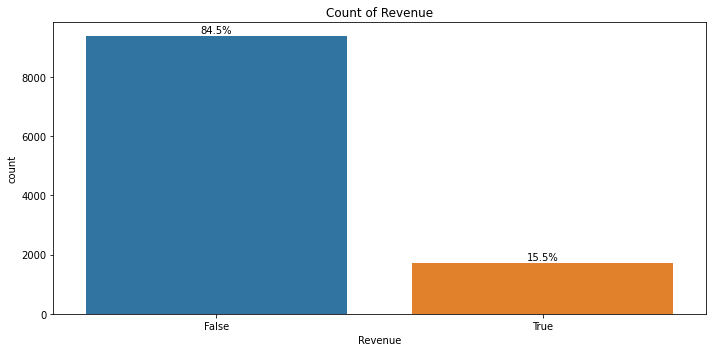

In [45]:
# Count plot
plt.figure(figsize = (10,5))
ax = sns.countplot(x=df['Revenue'])
ax.set_title("Count of Revenue")

# Count percentage of each Class
total = len(df)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')
plt.tight_layout()
plt.show()

As seen above, the target variable - Revenue, is severely imbalanced. False class makes up majority of the feature with a total of 84.5%. True class only consists of 15.5% of the feature. This shows the conversion rate of visitors to revenue is rather low.

**Analyze features grouped by Revenue**

Analysis of levels within categorical variables

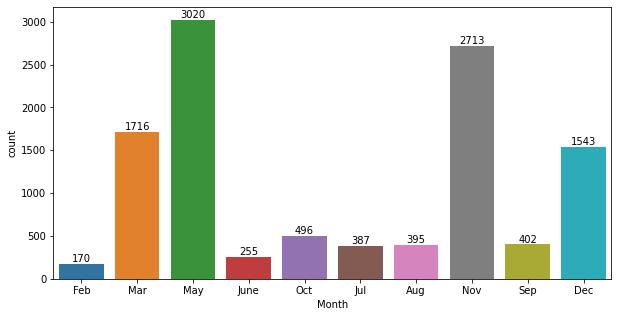

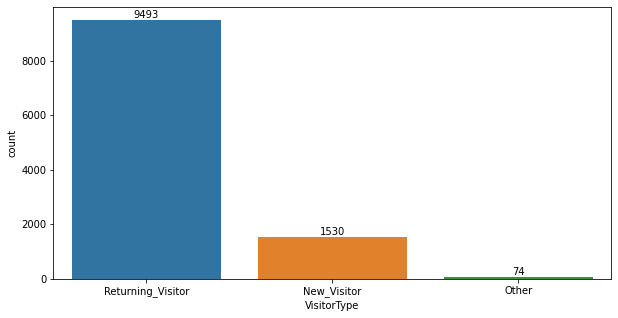

In [48]:
df_cat = df[['Month', 'VisitorType']]

for i, col in enumerate(df_cat.columns):
    plt.figure(figsize = (10,5))
    ax = sns.countplot(x=col, data=df_cat)
    ax.bar_label(ax.containers[0])    

- March, May, November and December are most active months
- Most of store visitors are returning visitors. This shows that the store is able captivate visitors which prompts thier return. However, the site may not be marketed well as amount of new visitors are relatively low.

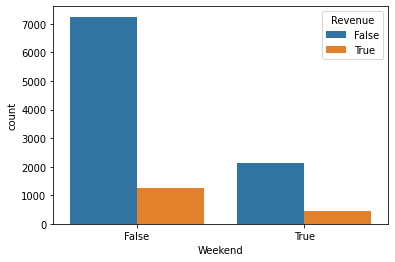

In [50]:
# count plot on two categorical variable
sns.countplot(x ='Weekend', hue = "Revenue", data = df)
 
# Show the plot
plt.show()

- In terms of generating revenue, there is a higher proportion of sales being generated over weekends as compared to weekdays. The company could look to list out more attractive deals over weekdays to attract potential customers. Increase customer engagement could potentially help improve the proportion of sales over the weekdays.

(0.0, 2000.0)

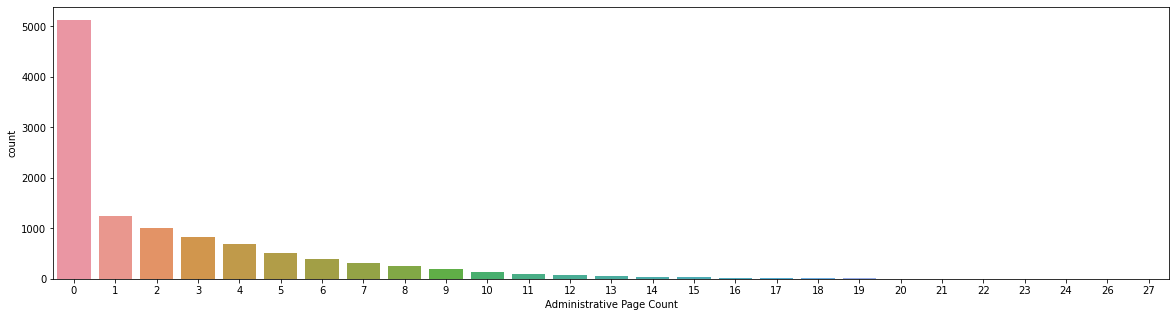

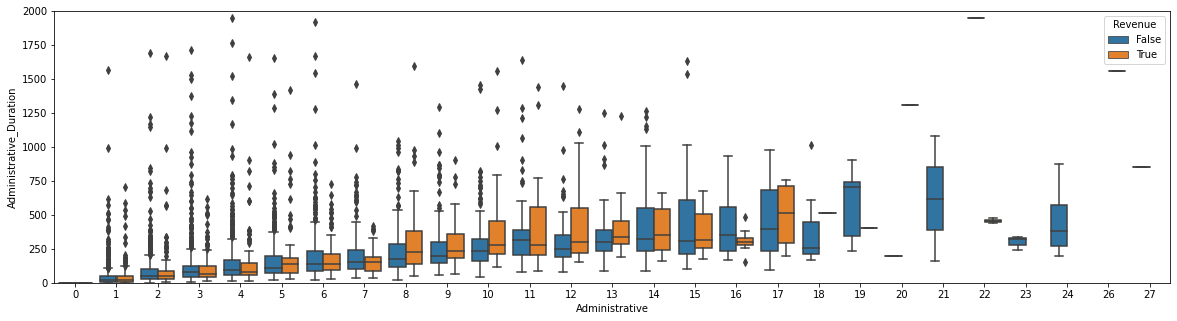

In [52]:
plt.figure(figsize=(20,5))
sns.countplot(x='Administrative',data=df)
plt.xlabel('Administrative Page Count')

plt.figure(figsize=(20,5))
sns.boxplot(x='Administrative',y='Administrative_Duration',hue='Revenue',data=df)
plt.ylim(0,2000)

- Visitors dont generally visit adminstrative page 
- However, those who visit between 8-18 pages seem to show some pattern of having higher possibility of bringing in Revenue.

(0.0, 2000.0)

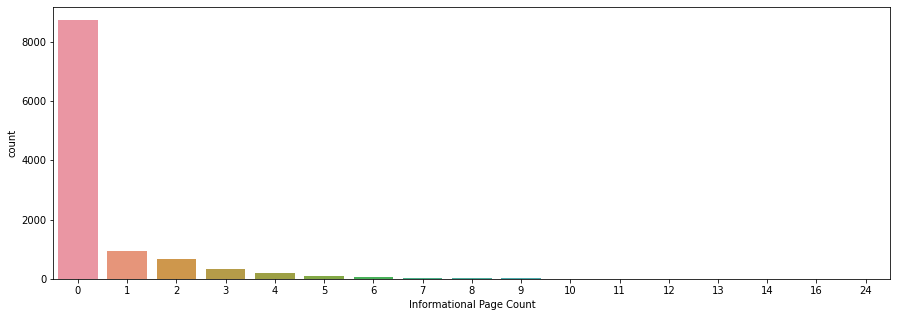

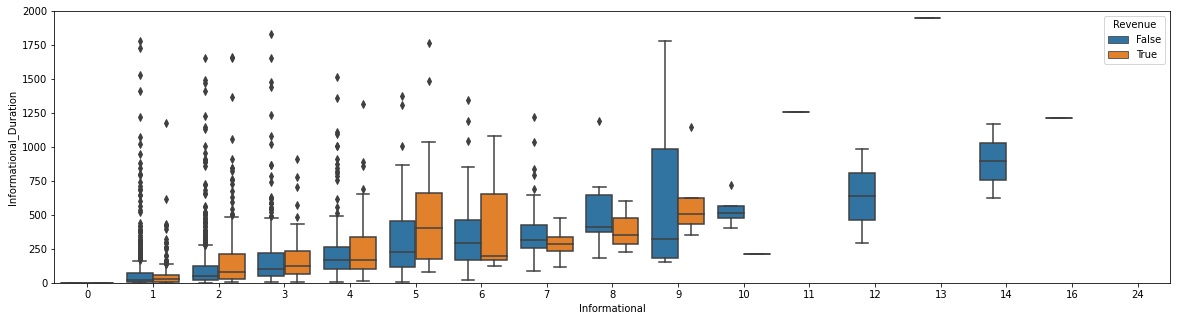

In [53]:
plt.figure(figsize=(15,5))
sns.countplot(x='Informational',data=df)
plt.xlabel('Informational Page Count')

plt.figure(figsize=(20,5))
sns.boxplot(x='Informational',y='Informational_Duration',hue='Revenue',data=df)
plt.ylim(0,2000)

- Similar to that of admistrative pages, visitors dont spend much time across informational pages too.
- However, those who visit between 2-6 pages tends to make a purchase within the store.

<AxesSubplot:xlabel='Revenue', ylabel='PageValues'>

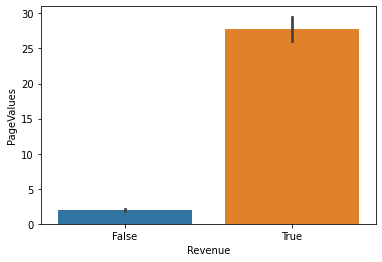

In [54]:
sns.barplot(y='PageValues',x='Revenue', data=df)

- Thers is a strong correlation between pages visited and generating Revenue.
- Essentially, if the visitor is surfing through more pages, there is a higher probability of generating revenue from that visitor.

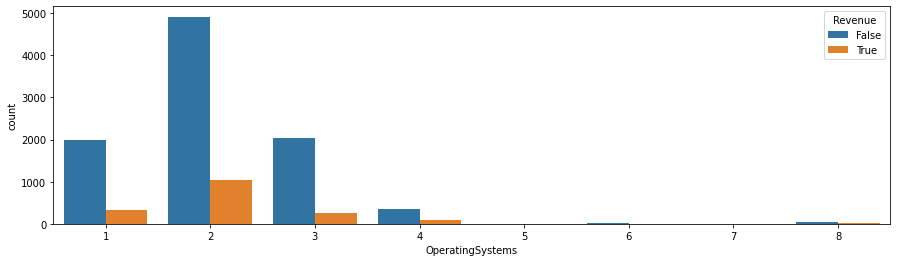

In [60]:
# count plot on two categorical variable
plt.figure(figsize=(15,4))
sns.countplot(x ='OperatingSystems', hue = "Revenue", data = df)
 
# Show the plot
plt.show()

- OS 2 contributes to most amount of Revenue and also is used by most visitors
- OS 1 and 3 is used by a good portion of visitors, however the probability of generating revenue from these visitors are relatively low. This could be the ad positioning across the browser. Apart from that, the UI and UX could also be a huge influence to the low revenue numbers from these OS.

-------
-------

## Feature Engineering

In [65]:
df2 = df.copy()

-----------
**Feature Transformation**

Transform skewed continuous variables to achieve approximate normal distribution

Continuous variables before transformation

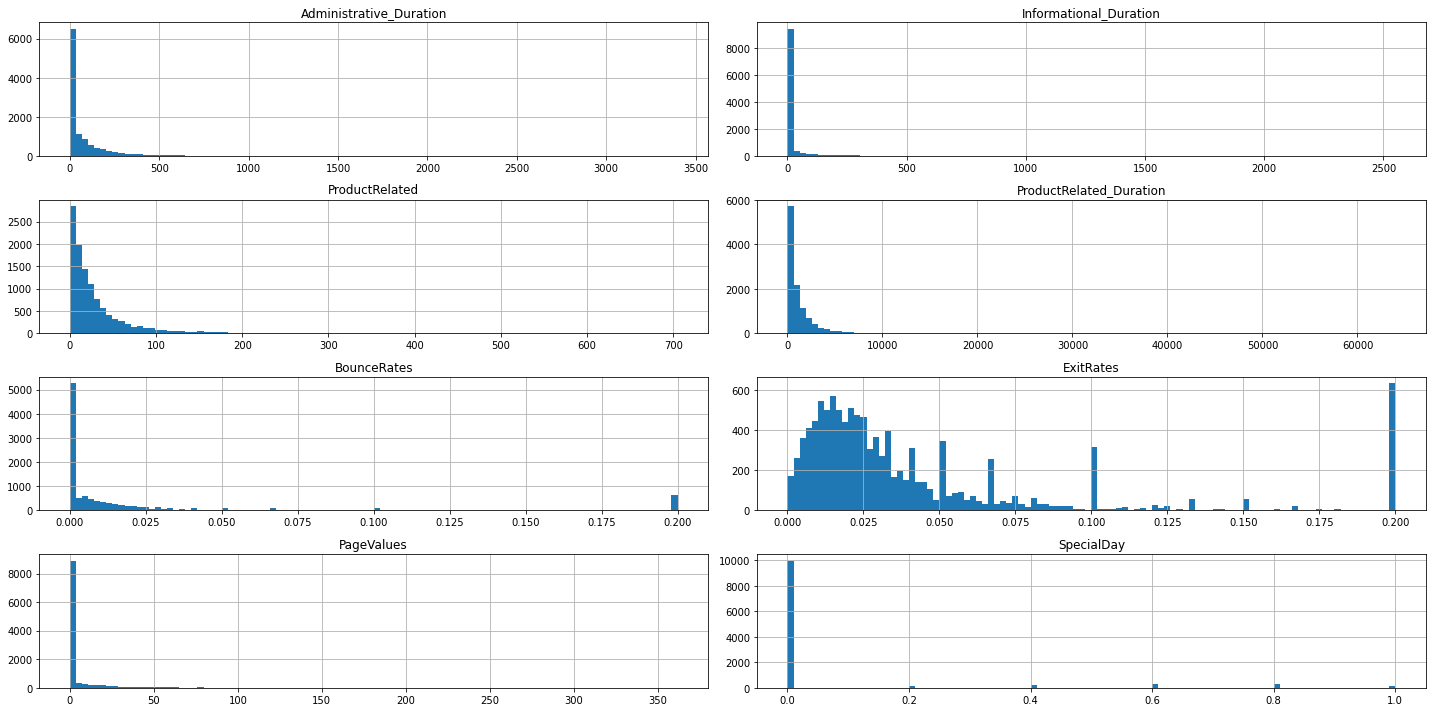

In [66]:
columns = ['Administrative_Duration','Informational_Duration','ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']
fig, axs = plt.subplots(4, 2, figsize=(20, 10))

for ax, col in zip(axs.flatten(), columns):
    df2.hist(column=col, ax=ax, bins = 100)
    plt.tight_layout()

**Apply Log Transformation**

Apply natural log of (1+x) to compute values close to 0

In [24]:
df_trans =np.log1p(df2[['Administrative_Duration','Informational_Duration','ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']])

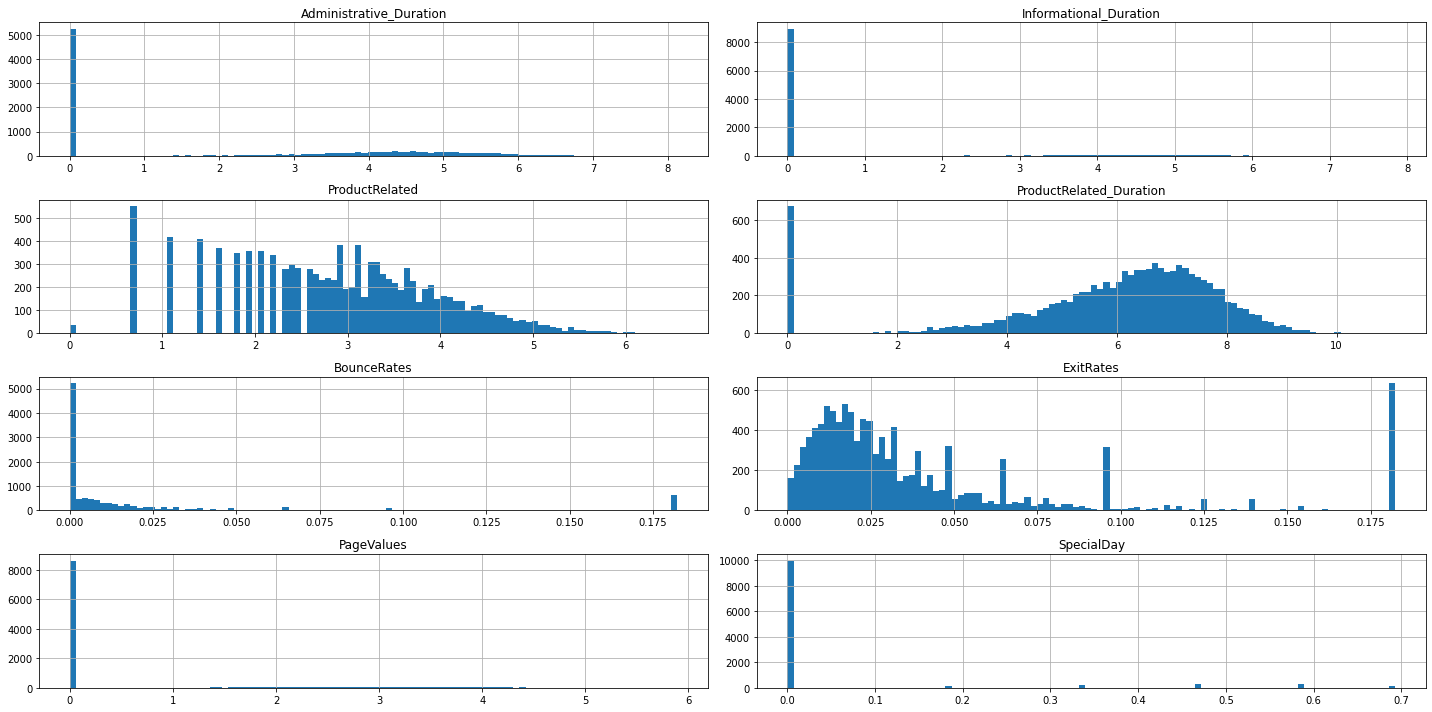

In [25]:
columns = ['Administrative_Duration','Informational_Duration','ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']
fig, axs = plt.subplots(4, 2, figsize=(20, 10))

for ax, col in zip(axs.flatten(), columns):
    df_trans.hist(column=col, ax=ax, bins = 100)
    plt.tight_layout()

Due to the nature of skewness, applying log transformations does not yeild a more desirable distribution. As such, to overcome such a distribution, we focus on applying machine learning models that are not heavilily impact by the non-normal distribution of continuous features.

**Apply Yeo-Johnson Transformation**

In [40]:
df_trans_2 = df2[['Administrative_Duration','Informational_Duration','ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']]

In [45]:
power = PowerTransformer(method='yeo-johnson', standardize=True)
data_trans_AD = power.fit_transform(df_trans_2[['Administrative_Duration']])
data_trans_ID = power.fit_transform(df_trans_2[['Informational_Duration']])
data_trans_PR = power.fit_transform(df_trans_2[['ProductRelated']])
data_trans_PRD = power.fit_transform(df_trans_2[['ProductRelated_Duration']])

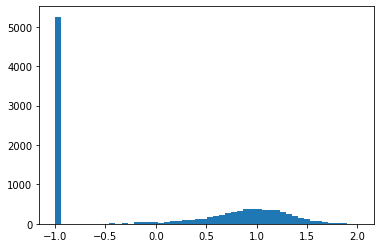

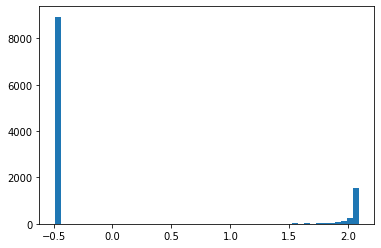

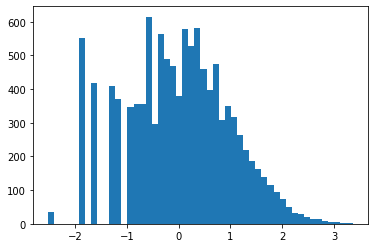

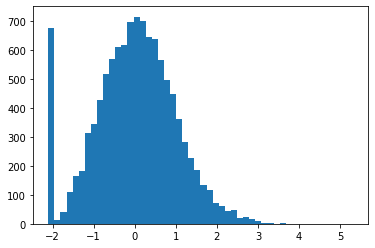

In [48]:
pyplot.hist(data_trans_AD, bins=50)
pyplot.show()

pyplot.hist(data_trans_ID, bins=50)
pyplot.show()

pyplot.hist(data_trans_PR, bins=50)
pyplot.show()

pyplot.hist(data_trans_PRD, bins=50)
pyplot.show()

Even with YJ transformation, the non-normal distribution nature of the features are still prominent. As such, the continous features are left as it is without any transformation.

-------------
**Feature Encoding**

Categorical Features are required to be represented numerically in order for it to be accepted by machine learning models. Although models such as decision trees can handle categorical features, skleans implementation of decision tree and ensembled model based on decision trees requires categorical features to be encoded.

Feature to be encoded : Month & VisitorType

Other categorical variables have already been reprsented by integers

In [67]:
df2 = pd.get_dummies(df2, columns=['Month','VisitorType'], drop_first=True)

Covert Weekend and Revenue to integers

In [68]:
df2['Revenue'] = df2['Revenue'].astype(int)
df2['Revenue'].value_counts()

0    9380
1    1717
Name: Revenue, dtype: int64

In [69]:
df2['Weekend'] = df2['Weekend'].astype(int)
df2['Weekend'].value_counts()

0    8517
1    2580
Name: Weekend, dtype: int64

In [53]:
np.shape(df2)

(11097, 27)

In [54]:
df2.dtypes

Administrative                     int64
Administrative_Duration          float64
Informational                      int64
Informational_Duration           float64
ProductRelated                     int64
ProductRelated_Duration          float64
BounceRates                      float64
ExitRates                        float64
PageValues                       float64
SpecialDay                       float64
OperatingSystems                   int64
Browser                            int64
Region                             int64
TrafficType                        int64
Weekend                            int64
Revenue                            int64
Month_Dec                          uint8
Month_Feb                          uint8
Month_Jul                          uint8
Month_June                         uint8
Month_Mar                          uint8
Month_May                          uint8
Month_Nov                          uint8
Month_Oct                          uint8
Month_Sep       

In [55]:
df2.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,VisitorType_Other,VisitorType_Returning_Visitor
count,11097.000000,11097.000000,11097.000000,11097.000000,11097.000000,11097.000000,11097.000000,11097.000000,11097.000000,11097.000000,...,11097.000000,11097.000000,11097.000000,11097.000000,11097.000000,11097.000000,11097.000000,11097.000000,11097.000000,11097.000000
mean,2.341984,81.629754,0.502658,34.540549,31.793998,1198.051909,0.022193,0.042987,5.948523,0.061440,...,0.015319,0.034874,0.022979,0.154636,0.272146,0.244480,0.044697,0.036226,0.006668,0.855456
std,3.342301,178.099128,1.262578,140.744461,44.695069,1931.046554,0.048427,0.048459,18.681972,0.199185,...,0.122826,0.183470,0.149844,0.361574,0.445085,0.429798,0.206647,0.186860,0.081392,0.351656
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,185.000000,0.000000,0.014286,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,1.000000,9.000000,0.000000,0.000000,18.000000,599.613333,0.003077,0.025128,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,4.000000,94.250000,0.000000,0.000000,38.000000,1466.088462,0.017143,0.050000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


-------------
**Feature Scaling**

In [70]:
# Apply MinMax normalization on features

scaler = MinMaxScaler()
df2[df2.columns] = scaler.fit_transform(df2[df2.columns]) 

In [71]:
df2.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,VisitorType_Other,VisitorType_Returning_Visitor
count,11097.000000,11097.000000,11097.000000,11097.000000,11097.000000,11097.000000,11097.000000,11097.000000,11097.000000,11097.000000,...,11097.000000,11097.000000,11097.000000,11097.000000,11097.000000,11097.000000,11097.000000,11097.000000,11097.000000,11097.000000
mean,0.086740,0.024018,0.020944,0.013549,0.045098,0.018727,0.110966,0.214933,0.016443,0.061440,...,0.015319,0.034874,0.022979,0.154636,0.272146,0.244480,0.044697,0.036226,0.006668,0.855456
std,0.123789,0.052401,0.052607,0.055207,0.063397,0.030185,0.242136,0.242297,0.051641,0.199185,...,0.122826,0.183470,0.149844,0.361574,0.445085,0.429798,0.206647,0.186860,0.081392,0.351656
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.009929,0.002892,0.000000,0.071429,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.037037,0.002648,0.000000,0.000000,0.025532,0.009373,0.015385,0.125641,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.148148,0.027731,0.000000,0.000000,0.053901,0.022917,0.085714,0.250000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


----------------------------
---------------------------

## Feature Selection

To prevent data leakage, the dataset is split into training and validation prior to Feature Selection. Feature importance would be analyzed and derived from the training set, and applied to the validation set

In [59]:
x = df2.drop('Revenue', axis = 1)
y = df2['Revenue']

In [61]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=1, stratify = y)

In [62]:
# Create Function to perform feature selection

def select_features(x_train, y_train, x_valid):
    
    # configure to top 15 features
    fs = SelectKBest(score_func=mutual_info_classif, k=10)
    
    # learn relationship from training data
    fs.fit(x_train, y_train)
    
    # filter train set
    cols = fs.get_support(indices=True)
    x_train_fs = x_train.iloc[:,cols]
    
    # filter test set
    x_valid_fs = x_valid.iloc[:,cols]
    
    return x_train_fs, x_valid_fs, fs

Feature 0: 0.013215
Feature 1: 0.017397
Feature 2: 0.006349
Feature 3: 0.003687
Feature 4: 0.023848
Feature 5: 0.032115
Feature 6: 0.026703
Feature 7: 0.045525
Feature 8: 0.173283
Feature 9: 0.004404
Feature 10: 0.001261
Feature 11: 0.000000
Feature 12: 0.000000
Feature 13: 0.016784
Feature 14: 0.002159
Feature 15: 0.000000
Feature 16: 0.001363
Feature 17: 0.000000
Feature 18: 0.001463
Feature 19: 0.002925
Feature 20: 0.000000
Feature 21: 0.010245
Feature 22: 0.000000
Feature 23: 0.000457
Feature 24: 0.000000
Feature 25: 0.011131


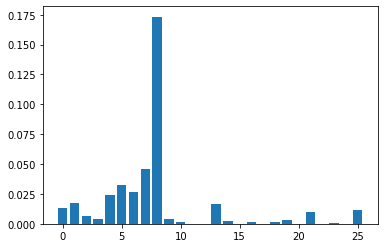

In [63]:
x_train_fs, x_valid_fs, fs = select_features(x_train, y_train, x_valid)

# What are scores for the features
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))
    
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

In [64]:
x_train_fs.dtypes

Administrative                   float64
Administrative_Duration          float64
ProductRelated                   float64
ProductRelated_Duration          float64
BounceRates                      float64
ExitRates                        float64
PageValues                       float64
TrafficType                      float64
Month_Nov                        float64
VisitorType_Returning_Visitor    float64
dtype: object

In [65]:
np.shape(x_train_fs)

(8877, 10)

In [66]:
x_valid_fs.dtypes

Administrative                   float64
Administrative_Duration          float64
ProductRelated                   float64
ProductRelated_Duration          float64
BounceRates                      float64
ExitRates                        float64
PageValues                       float64
TrafficType                      float64
Month_Nov                        float64
VisitorType_Returning_Visitor    float64
dtype: object

In [67]:
np.shape(x_valid_fs)

(2220, 10)

-------------
-------------

## Modelling

**Balancing Dataset**

- As the dataset is imbalanced with Revenue = 1 being the minority class, we need to perform some level of class balancing. 

- Due to large difference between the minority and majority class, the recommended approach would be to couple oversampling with undersampling. As such, SMOTE is used to oversample the minority class while RandomUndersampler is used to undersample the majority class

- To much Oversampling can result in unreliable training due to data being synthetic representations in the case of SMOTE. On the other hand, if the dataset is only undersampled, we could lose important information that may be critical for training.

- Hence to balance the trade off, coupling oversampling and undersampling would be a better stratergy

In [95]:
over = SMOTE(sampling_strategy=0.6)
under = RandomUnderSampler(sampling_strategy=0.7)

In [96]:
# Create Pipeline for sampling

# Oversample first before Undersampling
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# Perform over and undersampling on the training set
x_balanced, y_balanced = pipeline.fit_resample(x_train_fs, y_train)

DV Counts Before Balancing

In [97]:
y_train.value_counts()

0.0    7503
1.0    1374
Name: Revenue, dtype: int64

DV Counts After Balancing

In [98]:
y_balanced.value_counts()

0.0    6430
1.0    4501
Name: Revenue, dtype: int64

**Save filtered and balanced training set to CSV**

In [99]:
balanced_dataset_test = pd.concat([x_balanced, y_balanced], axis=1)

In [100]:
balanced_dataset_test

,Administrative,Administrative_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,TrafficType,Month_Nov,VisitorType_Returning_Visitor,Revenue
0,0.000000,0.000000,0.007092,0.007097,0.000000,0.250000,0.000000,0.263158,0.0,1.0,0.0
1,0.037037,0.002648,0.065248,0.063845,0.000000,0.008974,0.000000,0.157895,0.0,1.0,0.0
2,0.148148,0.028393,0.059574,0.033957,0.000000,0.056202,0.097395,0.052632,0.0,1.0,0.0
3,0.148148,0.038838,0.009929,0.022092,0.180000,0.146429,0.000000,0.368421,0.0,1.0,0.0
4,0.000000,0.000000,0.019858,0.005179,0.000000,0.076923,0.000000,0.000000,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
10926,0.156115,0.070487,0.051048,0.026788,0.000000,0.039496,0.119441,0.157895,0.0,1.0,1.0
10927,0.007636,0.000546,0.137179,0.036441,0.011025,0.059675,0.038808,0.147044,0.0,1.0,1.0
10928,0.190553,0.046116,0.014720,0.006797,0.000000,0.042400,0.000000,0.052632,1.0,0.0,1.0
10929,0.000000,0.000000,0.017567,0.014157,0.000000,0.236678,0.034698,0.028847,0.0,1.0,1.0


In [101]:
balanced_dataset_test.to_csv('balanced_dataset_test.csv', index = False)

**Save filtered validation set to CSV**

In [102]:
valid_set = pd.concat([x_valid_fs, y_valid], axis=1)

In [103]:
valid_set.to_csv('valid_set.csv', index=False)

In [4]:
balanced_dataset = pd.read_csv('/notebooks/E-Commerce_Purchasing_Cls/balanced_dataset_test.csv')

In [5]:
x_train = balanced_dataset.drop('Revenue', axis=1)
y_train = balanced_dataset['Revenue']

In [6]:
validation_dataset = pd.read_csv('/notebooks/E-Commerce_Purchasing_Cls/valid_set.csv')

In [7]:
x_valid = validation_dataset.drop('Revenue', axis=1)
y_valid = validation_dataset['Revenue']

---------

**Random Forest**

Basic Model

In [10]:
rf_clf = RandomForestClassifier()
rf_clf.fit(x_train,y_train)

y_train_pred = rf_clf.predict(x_train)
y_valid_pred = rf_clf.predict(x_valid)

print('Confusion Matrix\n',confusion_matrix(y_valid,y_valid_pred))

Confusion Matrix
 [[1703  174]
 [ 103  240]]


In [11]:
# Define classes within Dependent Variable
target_names = ['0', '1'] 

print("Training Set\n",classification_report(y_train, y_train_pred, target_names=target_names))
print("Validation Set\n",classification_report(y_valid, y_valid_pred, target_names=target_names))

Training Set
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6430
           1       1.00      1.00      1.00      4501

    accuracy                           1.00     10931
   macro avg       1.00      1.00      1.00     10931
weighted avg       1.00      1.00      1.00     10931

Validation Set
               precision    recall  f1-score   support

           0       0.94      0.91      0.92      1877
           1       0.58      0.70      0.63       343

    accuracy                           0.88      2220
   macro avg       0.76      0.80      0.78      2220
weighted avg       0.89      0.88      0.88      2220



Tuned Model

In [120]:
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [20, 30, 40],
    'min_samples_leaf': [5, 10, 15],
    'min_samples_split': [2, 6, 10],
    'n_estimators': [80, 120, 150, 200]
}

rf_clf = RandomForestClassifier()
grid_search_rf = GridSearchCV(estimator = rf_clf, param_grid = param_grid, 
                          cv = 4, n_jobs = -1)


In [121]:
grid_search_rf.fit(x_train, y_train)
grid_search_rf.best_params_

{'bootstrap': False,
 'max_depth': 40,
 'min_samples_leaf': 5,
 'min_samples_split': 10,
 'n_estimators': 120}

Train the model across the entire training set using identified best hyperparameters

In [20]:
# Retrain model with best hyperparameters

rf_clf_tuned = RandomForestClassifier(bootstrap=False,
                                      max_depth=40,
                                      min_samples_leaf=5,
                                      min_samples_split=10,
                                      n_estimators=120)
rf_clf_tuned.fit(x_train,y_train)
y_train_tuned_pred = rf_clf_tuned.predict(x_train)
y_valid_tuned_pred = rf_clf_tuned.predict(x_valid)

print('Confusion Matrix\n',confusion_matrix(y_valid,y_valid_tuned_pred))

Confusion Matrix
 [[1700  177]
 [  95  248]]


In [21]:
# Define classes within Dependent Variable

target_names = ['0', '1'] 

print("Training Set\n",classification_report( y_train, y_train_tuned_pred, target_names=target_names))
print("Validation Set\n",classification_report(y_valid, y_valid_tuned_pred, target_names=target_names))

Training Set
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      6430
           1       0.97      0.97      0.97      4501

    accuracy                           0.98     10931
   macro avg       0.98      0.97      0.97     10931
weighted avg       0.98      0.98      0.98     10931

Validation Set
               precision    recall  f1-score   support

           0       0.95      0.91      0.93      1877
           1       0.58      0.72      0.65       343

    accuracy                           0.88      2220
   macro avg       0.77      0.81      0.79      2220
weighted avg       0.89      0.88      0.88      2220



-------
**K Nearest Neighbours**

In [14]:
mean_acc = np.zeros(20)
for i in range(1,21):
    #Train Model and Predict  
    knn = KNeighborsClassifier(n_neighbors = i).fit(x_train,y_train)
    y_pred_knn= knn.predict(x_valid)
    mean_acc[i-1] = metrics.accuracy_score(y_valid, y_pred_knn)
    
mean_acc

array([0.81531532, 0.83828829, 0.81531532, 0.83693694, 0.81081081,
       0.82567568, 0.80855856, 0.83018018, 0.81486486, 0.83018018,
       0.81441441, 0.82792793, 0.81261261, 0.82792793, 0.81756757,
       0.83018018, 0.81621622, 0.83063063, 0.81981982, 0.83243243])

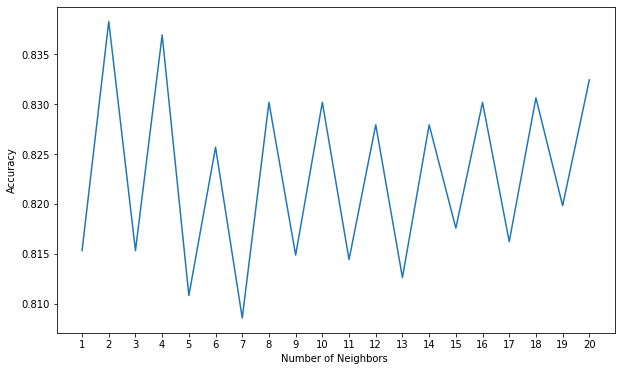

In [15]:
loc = np.arange(1,21,step=1.0)
plt.figure(figsize = (10, 6))
plt.plot(range(1,21), mean_acc)
plt.xticks(loc)
plt.xlabel('Number of Neighbors ')
plt.ylabel('Accuracy')
plt.show()

In [16]:
KNN_tuned = KNeighborsClassifier(n_neighbors = 2)
KNN_tuned.fit(x_train, y_train)

y_train_KNN_tuned = KNN_tuned.predict(x_train)
y_valid_KNN_tuned = KNN_tuned.predict(x_valid)
print('Confusion Matrix\n',confusion_matrix(y_valid,y_valid_KNN_tuned))

Confusion Matrix
 [[1705  172]
 [ 187  156]]


In [17]:
target_names = ['0', '1'] 

print("Training Set\n",classification_report(y_train, y_train_KNN_tuned, target_names=target_names))
print("Validation Set\n",classification_report(y_valid, y_valid_KNN_tuned, target_names=target_names))

Training Set
               precision    recall  f1-score   support

           0       0.97      1.00      0.99      6430
           1       1.00      0.96      0.98      4501

    accuracy                           0.98     10931
   macro avg       0.99      0.98      0.98     10931
weighted avg       0.98      0.98      0.98     10931

Validation Set
               precision    recall  f1-score   support

           0       0.90      0.91      0.90      1877
           1       0.48      0.45      0.46       343

    accuracy                           0.84      2220
   macro avg       0.69      0.68      0.68      2220
weighted avg       0.84      0.84      0.84      2220



Tuned Model

In [133]:
params = { 'n_neighbors' : [2,3,4,5,7,9,11,13],
           'weights' : ['uniform','distance'],
           'metric' : ['minkowski','euclidean','manhattan']
         }

knn = KNeighborsClassifier()
grid_search_knn = GridSearchCV(estimator = knn, param_grid = params, cv = 4, n_jobs = -1)


In [134]:
grid_search_knn.fit(x_train, y_train)
grid_search_knn.best_params_

{'metric': 'manhattan', 'n_neighbors': 2, 'weights': 'distance'}

In [22]:
# Retrain model with best hyperparameters

KNN_tuned_2 = KNeighborsClassifier(n_neighbors = 2, metric = 'manhattan', weights = 'distance')
KNN_tuned_2.fit(x_train, y_train)

y_train_KNN_tuned_2 = KNN_tuned_2.predict(x_train)
y_valid_KNN_tuned_2 = KNN_tuned_2.predict(x_valid)
print('Confusion Matrix\n',confusion_matrix(y_valid,y_valid_KNN_tuned_2))

Confusion Matrix
 [[1664  213]
 [ 178  165]]


In [23]:
target_names = ['0', '1'] 

print("Training Set\n",classification_report(y_train, y_train_KNN_tuned, target_names=target_names))
print("Validation Set\n",classification_report(y_valid, y_valid_KNN_tuned, target_names=target_names))

Training Set
               precision    recall  f1-score   support

           0       0.97      1.00      0.99      6430
           1       1.00      0.96      0.98      4501

    accuracy                           0.98     10931
   macro avg       0.99      0.98      0.98     10931
weighted avg       0.98      0.98      0.98     10931

Validation Set
               precision    recall  f1-score   support

           0       0.90      0.91      0.90      1877
           1       0.48      0.45      0.46       343

    accuracy                           0.84      2220
   macro avg       0.69      0.68      0.68      2220
weighted avg       0.84      0.84      0.84      2220



-------

**Support Vector Machines**

Basic Model

In [29]:
svm = SVC()
svm.fit(x_train, y_train)

y_train_pred_svm = svm.predict(x_train)
y_valid_pred_svm = svm.predict(x_valid)

print('Confusion Matrix\n',confusion_matrix(y_valid,y_valid_pred))

Confusion Matrix
 [[1703  174]
 [ 103  240]]


In [139]:
target_names = ['0', '1'] 

print("Training Set\n",classification_report(y_train, y_train_pred_svm, target_names=target_names))
print("Validation Set\n",classification_report(y_valid, y_valid_pred_svm, target_names=target_names))

Training Set
               precision    recall  f1-score   support

           0       0.82      0.92      0.87      6430
           1       0.86      0.71      0.78      4501

    accuracy                           0.84     10931
   macro avg       0.84      0.82      0.82     10931
weighted avg       0.84      0.84      0.83     10931

Validation Set
               precision    recall  f1-score   support

           0       0.94      0.91      0.92      1877
           1       0.58      0.67      0.62       343

    accuracy                           0.87      2220
   macro avg       0.76      0.79      0.77      2220
weighted avg       0.88      0.87      0.88      2220



Tuned Model

In [30]:
params = {'C': [0.1,1, 10, 100], 
          'gamma': [1,0.1,0.01,0.001],
          'kernel': ['rbf', 'poly', 'sigmoid']}

svm = SVC()
grid_search_svm = GridSearchCV(estimator = svm, param_grid = params, cv = 4, n_jobs = -1)

In [141]:
grid_search_svm.fit(x_train, y_train)
grid_search_svm.best_params_

{'C': 100, 'gamma': 1, 'kernel': 'rbf'}

In [31]:
# Retrain model with best hyperparameters

svm_tuned = SVC(C=100, gamma=1, kernel='rbf')
svm_tuned.fit(x_train, y_train)

y_train_svm_tuned = svm_tuned.predict(x_train)
y_valid_svm_tuned = svm_tuned.predict(x_valid)
print('Confusion Matrix\n',confusion_matrix(y_valid,y_valid_svm_tuned))

Confusion Matrix
 [[1696  181]
 [  99  244]]


In [32]:
target_names = ['0', '1'] 

print("Training Set\n",classification_report(y_train, y_train_svm_tuned, target_names=target_names))
print("Validation Set\n",classification_report(y_valid, y_valid_svm_tuned, target_names=target_names))

Training Set
               precision    recall  f1-score   support

           0       0.85      0.92      0.89      6430
           1       0.87      0.78      0.82      4501

    accuracy                           0.86     10931
   macro avg       0.86      0.85      0.85     10931
weighted avg       0.86      0.86      0.86     10931

Validation Set
               precision    recall  f1-score   support

           0       0.94      0.90      0.92      1877
           1       0.57      0.71      0.64       343

    accuracy                           0.87      2220
   macro avg       0.76      0.81      0.78      2220
weighted avg       0.89      0.87      0.88      2220



----------
-------------

## Evaluating Model Performance

In [34]:
df_test = pd.read_csv('online_shopper_test_set.csv')

# Encode Categorical features
df_test = pd.get_dummies(df_test, columns=['Month','VisitorType'], drop_first=True)
df_test['Revenue'] = df_test['Revenue'].astype(int)
df_test['Revenue'].value_counts()
df_test['Weekend'] = df_test['Weekend'].astype(int)
df_test['Weekend'].value_counts()

# Apply MinMax normalization on features
scaler = MinMaxScaler()
df_test[df_test.columns] = scaler.fit_transform(df_test[df_test.columns]) 

# Filter features based on Feature Selection 
df_test = df_test[['Administrative', 'Administrative_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates',
            'PageValues', 'TrafficType', 'Month_Nov', 'VisitorType_Returning_Visitor', 'Revenue']]

# Label x and y values 
x_test = df_test.drop('Revenue', axis = 1)
y_test = df_test['Revenue']

In [40]:
y_test_rf_pred = rf_clf_tuned.predict(x_test)
print("Test Set (RF)\n",classification_report(y_test, y_test_rf_pred, target_names=target_names))

Test Set (RF)
               precision    recall  f1-score   support

           0       0.94      0.93      0.94      1042
           1       0.65      0.67      0.66       191

    accuracy                           0.89      1233
   macro avg       0.80      0.80      0.80      1233
weighted avg       0.89      0.89      0.89      1233



In [38]:
y_test_knn_tuned = KNN_tuned_2.predict(x_test)
print("Test Set (KNN)\n",classification_report(y_test, y_test_knn_tuned, target_names=target_names))

Test Set (KNN)
               precision    recall  f1-score   support

           0       0.92      0.90      0.91      1042
           1       0.50      0.54      0.52       191

    accuracy                           0.85      1233
   macro avg       0.71      0.72      0.72      1233
weighted avg       0.85      0.85      0.85      1233



In [39]:
y_test_svm_tuned = svm_tuned.predict(x_test)
print("Test Set (SVM)\n",classification_report(y_test, y_test_svm_tuned, target_names=target_names))

Test Set (SVM)
               precision    recall  f1-score   support

           0       0.95      0.90      0.92      1042
           1       0.58      0.72      0.64       191

    accuracy                           0.88      1233
   macro avg       0.76      0.81      0.78      1233
weighted avg       0.89      0.88      0.88      1233



Although the highest performance was observed from random forest model, SVM was able to a more balance recall value across both classes. Hence the trained SVM model is more reliable given an unbalanced test set.

## Clustering

In [62]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [73]:
pca = PCA(5)
df3 = pca.fit_transform(df2)

In [74]:
kmeans = KMeans(4)
kmeans.fit(df3)

KMeans(n_clusters=4)

In [75]:
identified_clusters = kmeans.fit_predict(df3)
identified_clusters

array([3, 3, 3, ..., 0, 0, 0], dtype=int32)

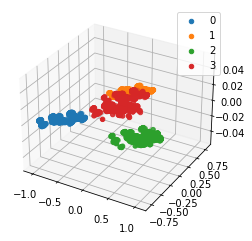

In [76]:
u_labels = np.unique(identified_clusters)
 
#plotting the results:
ax = plt.subplot(111, projection='3d', label="bla")
 
for i in u_labels:
    ax.scatter(df3[identified_clusters == i , 0] , df3[identified_clusters == i,1] , label = i)
plt.legend()
plt.show()